In [1]:
%load_ext autoreload
%autoreload 2

# Examining ChiX

## Preface

We know from the [bpRNA-1m](https://bprna.cgrb.oregonstate.edu/index.html) dataset that there are a lot of different motifs in natural RNAs. The table below shows the number of occurences of each structural motif in the database and highlights how much more common some are compared to others. One thing to note is the abundance of pseudoknots, which are structurally more complex features compared to other motifs and are not predicted by design by many structure-prediction algorithms. 

In [2]:
bpRNA_motifs = {'Hairpins': 708144,
                'Bulges': 517672,
                'Multi Loops': 317046,
                'Internal Loops': 538670,
                'Pseudoknots': 57686,
                'Stems': 2075928,
                'Unpaired Regions': 229468,
                'Segments': 1019586}

for k, v in bpRNA_motifs.items():
    print(f'% {k}:\t', v / sum(bpRNA_motifs.values()))

% Hairpins:	 0.12959701328648293
% Bulges:	 0.09473884557666264
% Multi Loops:	 0.05802240035137806
% Internal Loops:	 0.09858167709820284
% Pseudoknots:	 0.010557080633944584
% Stems:	 0.3799143515976721
% Unpaired Regions:	 0.041994802532850185
% Segments:	 0.18659382892280663


In this notebook we will nonetheless examine ChiX and its mutants for such motifs.

## Imports

In [3]:
import os
from subprocess import Popen, PIPE

import ViennaRNA
from varnaapi import Structure
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from run_bpRNA import write_dbn, execute_perl_script, aggregate_motifs

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
fn = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
data = pd.read_csv(fn)
data_merged = pd.read_csv(fn_merged)

try:
    data = data.drop(columns='Unnamed: 0')
    data_merged = data_merged.drop(columns='Unnamed: 0')
except:
    pass

In [5]:
def show_rna_structure(rna_structure, seq, resolution = 3, algorithm = 'radiate', annotate: bool = False, highlight_kwrgs: dict = None):
    try:
        v = Structure(structure=rna_structure, sequence=seq)
        v._params['resolution'] = resolution
        v._params['algorithm'] = algorithm
        if annotate:
            v._params['autoHelices'] = True
            v._params['autoInteriorLoops'] = True
            v._params['autoTerminalLoops'] = True
        if highlight_kwrgs:
            v.add_highlight_region(**highlight_kwrgs)
        v.show()
        # v.savefig("example.png", show=True)
    except FileNotFoundError:
        print('No Java found, could not visualise')
        pass

    

In [6]:
chix = data[(data['Interactor 1'] == 'chiX') | (data['Interactor 2'] == 'chiX')]

In [7]:
s = ''
# ChiX
seq = chix['Sequence 1'].iloc[0] if chix['Interactor 1'].iloc[0] == 'chiX' else chix['Sequence 2'].iloc[0]
folded = ViennaRNA.fold(seq, s)
folded

show_rna_structure(folded[0], seq)

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).........(((((((((.....((........))(((((((....))))))))))))))))', '-o', '/tmp/tmproop7qjf.png', '-resolution', '3']
No Java found, could not visualise


# Scott's mutations

In [8]:
fn_mutations = os.path.join('data', 'scott_mutations.fasta')

muts = load_seq_from_FASTA(fn_mutations, as_type='dict')


In [9]:
print('Synthetic sequence \t', muts['Syn_ChiX_20-D'])
print('Normal sequence \t', chix['Sequence 1'].iloc[0] if chix['Interactor 1'].iloc[0] == 'chiX' else chix['Sequence 2'].iloc[0])

Synthetic sequence 	 ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT
Normal sequence 	 ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT


In [10]:
s = ''
# Synthetic ChiX
seq = muts['Syn_ChiX_20-D']
folded = ViennaRNA.fold(seq, s)
folded

show_rna_structure(folded[0], seq)

# v.savefig("example.png", show=True)

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).......................................((((((((((....))))))))))......', '-o', '/tmp/tmp5h94hcj1.png', '-resolution', '3']
No Java found, could not visualise


In [11]:
chix

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB
279,chiX,rpoS,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:947210",NaN,mRNA,No Interaction,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTCAGAATACGCTGAAAGTTCATGATTTAAATGAAGATGCGG...,sRNATarBase
353,chiX,citA,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945233",trans-encoded antisense RNA,mRNA,Repression,['46..57'],['-37..-26'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGTTGCAGCTTAACGAGAATAAACAGTTTGCATTTTTCCAAAGAC...,sRNATarBase
374,chiX,chiP,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945296",trans-encoded antisense RNA,mRNA,Repression,['81..92'],['45..56'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGCGTACGTTTAGTGGCAAACGTAGTACGCTGGCGCTGGCTATCG...,sRNATarBase
408,chiX,chbC,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945982",trans-encoded antisense RNA,mRNA,Repression,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTAATGTTATTGCATCGCTTGAAAAGGTACTCCTCCCTTTTG...,sRNATarBase


## Add EGFP and cyRFP1 to targets

The sequence for EGFP can be found via the [Fluorescent Protein Database](https://www.fpbase.org/protein/egfp/) and is the following:

MVSKGEELFT GVVPILVELD GDVNGHKFSV SGEGEGDATY GKLTLKFICT TGKLPVPWPT LVTTLTYGVQ CFSRYPDHMK QHDFFKSAMP EGYVQERTIF FKDDGNYKTR AEVKFEGDTL VNRIELKGID FKEDGNILGH KLEYNYNSHN VYIMADKQKN GIKVNFKIRH NIEDGSVQLA DHYQQNTPIG DGPVLLPDNH YLSTQSALSK DPNEKRDHMV LLEFVTAAGI TLGMDELYK

The source DNA for EGFP can be found on [Addgene](https://www.addgene.org/54762/) but was modified by Scott to be the following (the first 26 nt are the ribosome binding site):

TACTAGAGAAAGAGGGGAAATACTAGTACCATATGCGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGA
GAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCGGTTATGGTGTTCAATGCTTTGCGAG
ATACCCAGATCATATGAAACAGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAAAGAACTATATTTTTCAAAGATGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTG
AAGGTGATACCCTTGTTAATAGAATCGAGTTAAAAGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAATTGGAATACAACTATAACTCACACAATGTATACATCATGGCAGACAAA
CAAAAGAATGGAATCAAAGTTAACTTCAAAATTAGACACAACATTGAAGATGGAAGCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAA
CCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGATCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAA


The source for cyRFP1 can also be found on [Addgene](https://www.addgene.org/84356/) but was modified by Scott to be the following (the first 26 nt are the ribosome binding site):

GATTTGTAACTAAAAACAAGAAACTTATGGTATCAAAAGGTGAAGAGCTGATTAAAGAGAACATGAGATCAAAGCTTTACTTAGAAGGCTCTGTGAATGGCCATCAGTTCAAATGCACCCACGAG
GGTGAAGGGAAACCTTATGAGGGTAAACAGACCAATCGAATTAAGGTTGTGGAAGGCGGCCCCTTACCTTTTGCATTCGACATATTGGCGACGATGTTCATGTACGGCTCTAAGGTTTTCATCAA
ATATCCGGCAGATTTGCCCGATTACTTCAAACAATCCTTTCCGGAGGGCTTTACATGGGAAAGAGTAATGGTGTTTGAAGACGGTGGTGTGCTGACTGCAACACAGGATACCTCACTTCAGGATG
GTGAACTGATCTACAACGTGAAACTGCGAGGAGTTAACTTTCCAGCAAATGGGCCAGTGATGCAAAAAAAAACCCTGGGATGGGAACCATCTACAGAAACGATGTATCCCGCCGATGGCGGATTA
GAGGGAAGGTGCGATAAAGCTCTGAAACTCGTTGGCGGCGGTCATTTACATGTGAACTTCAAAACGACTTATAAAAGTAAGAAACCGGTTAAGATGCCGGGCGTACACTATGTGGATCGACGTTT
GGAACGGATAAAAGAGGCGGATAACGAAACTTACGTGGAGCAGTACGAACATGCTGTAGCCCGGTATAGCAACTTAGGTGGCGGTATGGACGAACTTTATAAATAA

In [12]:
egfp_seq = 'TACTAGAGAAAGAGGGGAAATACTAGTACCATATGCGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCGGTTATGGTGTTCAATGCTTTGCGAGATACCCAGATCATATGAAACAGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAAAGAACTATATTTTTCAAAGATGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATAGAATCGAGTTAAAAGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAATTGGAATACAACTATAACTCACACAATGTATACATCATGGCAGACAAACAAAAGAATGGAATCAAAGTTAACTTCAAAATTAGACACAACATTGAAGATGGAAGCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGATCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAA'
cyrfp1_seq = 'GATTTGTAACTAAAAACAAGAAACTTATGGTATCAAAAGGTGAAGAGCTGATTAAAGAGAACATGAGATCAAAGCTTTACTTAGAAGGCTCTGTGAATGGCCATCAGTTCAAATGCACCCACGAGGGTGAAGGGAAACCTTATGAGGGTAAACAGACCAATCGAATTAAGGTTGTGGAAGGCGGCCCCTTACCTTTTGCATTCGACATATTGGCGACGATGTTCATGTACGGCTCTAAGGTTTTCATCAAATATCCGGCAGATTTGCCCGATTACTTCAAACAATCCTTTCCGGAGGGCTTTACATGGGAAAGAGTAATGGTGTTTGAAGACGGTGGTGTGCTGACTGCAACACAGGATACCTCACTTCAGGATGGTGAACTGATCTACAACGTGAAACTGCGAGGAGTTAACTTTCCAGCAAATGGGCCAGTGATGCAAAAAAAAACCCTGGGATGGGAACCATCTACAGAAACGATGTATCCCGCCGATGGCGGATTAGAGGGAAGGTGCGATAAAGCTCTGAAACTCGTTGGCGGCGGTCATTTACATGTGAACTTCAAAACGACTTATAAAAGTAAGAAACCGGTTAAGATGCCGGGCGTACACTATGTGGATCGACGTTTGGAACGGATAAAAGAGGCGGATAACGAAACTTACGTGGAGCAGTACGAACATGCTGTAGCCCGGTATAGCAACTTAGGTGGCGGTATGGACGAACTTTATAAATAA'

egfp = chix.iloc[-1][['Interactor 1', 'ID 1', 'Category 1', 'Binding position 1', 'Sequence 1']].to_dict()
for k, v in zip(['Interactor 2', 'ID 2', 'Category 2', 'Regulation', 'Binding position 2', 'Sequence 2', 'Source DB'], ['EGFP', 'https://www.addgene.org/54762/', 'mRNA', 'Repression', "['NA']", egfp_seq, 'Addgene']):
    egfp[k] = [v]
cyrfp1 = chix.iloc[-1][['Interactor 1', 'ID 1', 'Category 1', 'Binding position 1', 'Sequence 1']].to_dict()
for k, v in zip(['Interactor 2', 'ID 2', 'Category 2', 'Regulation', 'Binding position 2', 'Sequence 2', 'Source DB'], ['cyRFP1', 'https://www.addgene.org/84356/', 'mRNA', 'Activator', "['NA']", cyrfp1_seq, 'Addgene']):
    cyrfp1[k] = [v]
    
data = pd.concat([data, pd.DataFrame.from_dict(egfp)])
data = pd.concat([data, pd.DataFrame.from_dict(cyrfp1)])

chix = data[(data['Interactor 1'] == 'chiX') | (data['Interactor 2'] == 'chiX')]
chix


,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB
279,chiX,rpoS,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:947210",NaN,mRNA,No Interaction,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTCAGAATACGCTGAAAGTTCATGATTTAAATGAAGATGCGG...,sRNATarBase
353,chiX,citA,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945233",trans-encoded antisense RNA,mRNA,Repression,['46..57'],['-37..-26'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGTTGCAGCTTAACGAGAATAAACAGTTTGCATTTTTCCAAAGAC...,sRNATarBase
374,chiX,chiP,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945296",trans-encoded antisense RNA,mRNA,Repression,['81..92'],['45..56'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGCGTACGTTTAGTGGCAAACGTAGTACGCTGGCGCTGGCTATCG...,sRNATarBase
408,chiX,chbC,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945982",trans-encoded antisense RNA,mRNA,Repression,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTAATGTTATTGCATCGCTTGAAAAGGTACTCCTCCCTTTTG...,sRNATarBase
0,chiX,EGFP,"chromosome:NC_000913.3, Gene ID:5061500",https://www.addgene.org/54762/,trans-encoded antisense RNA,mRNA,Repression,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,TACTAGAGAAAGAGGGGAAATACTAGTACCATATGCGTAAAGGAGA...,Addgene
0,chiX,cyRFP1,"chromosome:NC_000913.3, Gene ID:5061500",https://www.addgene.org/84356/,trans-encoded antisense RNA,mRNA,Activator,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,GATTTGTAACTAAAAACAAGAAACTTATGGTATCAAAAGGTGAAGA...,Addgene


# Analyse synthetic chiX binding to all targets

In [13]:
s = 'syn_chiX'
mrnas = {m['Interactor 2']: m['Sequence 2']
         for _, m in data[['Interactor 2', 'Sequence 2']].iterrows() if type(m['Sequence 2']) == str}

len(mrnas)

283

### Run IntaRNA

In [14]:
run_intarna = False

config = {
    "experiment": {
        "purpose": "tests",
    },
    "data": {},
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

In [15]:
config['interaction_simulator']['simulator_kwargs']['outcsvcols'] = "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2"

In [16]:
def simulate_IntaRNA_local(query: dict,
                           targets: dict,
                           sim_kwargs={}):
    fn1 = data_writer.output(data=query, out_type='fasta',
                             out_name='query', byseq=True, return_path=True)
    fn2 = data_writer.output(data=targets, out_type='fasta',
                             out_name='targets', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn2

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


if run_intarna:
    sim_data = {}
    for s, sseq in muts.items():
        sim_data[s] = {}
        sim_data[s] = simulate_IntaRNA_local(query={s: sseq},
                                            targets=mrnas,
                                            sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

        data_writer.output(data=sim_data, out_type='json',
                        out_name='inter_data_raw', overwrite=True)
    print(data_writer.write_dir)

KeyboardInterrupt: 

### Load back in

In [ ]:
# fn = os.path.join(data_writer.write_dir, 'inter_data_raw.json')
# if not os.path.isfile(fn):
fn_sim = './data/tests/2023_12_12_170150/inter_data_raw.json'
sim_data_l = load_json_as_dict(fn_sim)

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': ''
}
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
        

In [ ]:
sim_data_l.keys()

dict_keys(['Syn_ChiX_20-D', 'MutagenesisVariant_1', 'MutagenesisVariant_2', 'MutagenesisVariant_3', 'MutagenesisVariant_4', 'MutagenesisVariant_5', 'MutagenesisVariant_6', 'MutagenesisVariant_7', 'MutagenesisVariant_8', 'MutagenesisVariant_9', 'MutagenesisVariant_10', 'MutagenesisVariant_11', 'MutagenesisVariant_12', 'MutagenesisVariant_13', 'MutagenesisVariant_14', 'MutagenesisVariant_15', 'MutagenesisVariant_16', 'MutagenesisVariant_17', 'MutagenesisVariant_18', 'MutagenesisVariant_19', 'MutagenesisVariant_20', 'MutagenesisVariant_21', 'MutagenesisVariant_22', 'MutagenesisVariant_23', 'MutagenesisVariant_24', 'MutagenesisVariant_25', 'MutagenesisVariant_26', 'MutagenesisVariant_27', 'MutagenesisVariant_28', 'MutagenesisVariant_29', 'MutagenesisVariant_30', 'MutagenesisVariant_31', 'MutagenesisVariant_32', 'MutagenesisVariant_33', 'MutagenesisVariant_34', 'MutagenesisVariant_35', 'MutagenesisVariant_36', 'MutagenesisVariant_37', 'MutagenesisVariant_38', 'MutagenesisVariant_39', 'Mutag

In [ ]:
sim_data_l['Syn_ChiX_20-D']

{'hfq': {'id1': 'hfq',
  'id2': 'Syn_ChiX_20-D',
  'E': '-4.72',
  'E_norm': '-0.460748',
  'bpList': '(4,59):(5,58):(6,56):(7,55):(8,54):(9,53):(10,52):(11,51):(12,50)',
  'hybridDPfull': '...(((((((((.........................................................................................................................................................................................................................................................................................................&.................................................))))))).))................................',
  'seedPu1': '0.0080755106771585074',
  'seedPu2': '0.73470881792585185',
  'seedStart1': '6',
  'seedStart2': '50',
  'seedEnd1': '12',
  'seedEnd2': '56'},
 'fhlA': {'id1': 'fhlA',
  'id2': 'Syn_ChiX_20-D',
  'E': '-8.04',
  'E_norm': '-0.802052',
  'bpList': '(95,60):(96,59):(97,58):(98,56):(99,55):(100,54):(101,53):(102,52):(103,51):(104,50):(105,49):(106,48)',
  'hybridDPfull': '...................

In [ ]:
len(sim_data_l['MutagenesisVariant_1'].keys())

283

### Run bpRNA

In [ ]:
# bpRNA

run_bpRNA = False


if run_bpRNA:

    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
        
    os.rmdir(data_writer.top_write_dir)
    data_writer.top_write_dir = os.path.dirname(fn)
    data_writer.reset_ensemble()
    data_writer.unsubdivide()

    for k1 in sim_data_l:
        data_writer.subdivide_writing('st')
        data_writer.subdivide_writing(k1, safe_dir_change=False)
        data_writer.unsubdivide()
        data_writer.subdivide_writing('dbn')
        data_writer.subdivide_writing(k1, safe_dir_change=False)

        for k2 in sim_data_l[k1]:
            bplist = sim_data_l[k1][k2]['bpList']
            # make_db(bplist, seq_len=len(db))
            db = sim_data_l[k1][k2]['hybridDPfull'].replace('&', '')
            try:
                seq = muts[k1] + \
                    data_merged[data_merged['Symbol'] == k2]['Sequence'].iloc[0]
            except IndexError:
                seq = muts[k1] + \
                    data[data['Interactor 2'] == k2]['Sequence 2'].iloc[0]
            fn = write_dbn(k1 + '_' + k2, data_writer.write_dir, id_name='arcZ', seq=seq, db=db)
            try:
                execute_perl_script(fn, fn.replace('.dbn', '').replace('dbn', 'st'))
            except:
                print(k1, k2)
    data_writer.unsubdivide()
                

In [42]:
motifs = aggregate_motifs(sim_data=sim_data_l, dir_st=os.path.join(os.path.dirname(fn_sim), 'st'))


/home/wadh6511/Kode/EvoScaper/notebooks_sRNA/run_bpRNA.py:54: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  structures = structures.reset_index().drop(columns='index')


## Visualise mutation differences

In [44]:
df_mutations = pd.DataFrame(flatten_listlike([[
    [k1, k2,
     v['hybridDPfull'].count('('),
     float(v['E']),
     float(sim_data_l['Syn_ChiX_20-D'][k2]['E']) - float(v['E']),
     float(sim_data_l['Syn_ChiX_20-D'][k2]['E_norm']) - float(v['E_norm']),
     float(sim_data_l['Syn_ChiX_20-D'][k2]['E']) / sim_data_l['Syn_ChiX_20-D'][k2]['hybridDPfull'].count(
         '(') - float(v['E']) / v['hybridDPfull'].count('(') if (float(sim_data_l['Syn_ChiX_20-D'][k2]['E']) < 0) & (float(v['E']) < 0) else 0.0,
     motifs[(motifs['sRNA'] == 'Syn_ChiX_20-D') & (motifs['Target'] == k2)]['Mean Length'].reset_index(drop=True) -
     motifs[(motifs['sRNA'] == k1) & (motifs['Target'] == k2)
            ]['Mean Length'].reset_index(drop=True),
     motifs[(motifs['sRNA'] == 'Syn_ChiX_20-D') & (motifs['Target'] == k2)]['Num in seq'].reset_index(drop=True) -
     motifs[(motifs['sRNA'] == k1) & (motifs['Target'] == k2)
            ]['Num in seq'].reset_index(drop=True),
     ] + [*v.values()] for k2, v in sim_data_l[k1].items()] for k1 in sim_data_l]),
    columns=['Interactor 1', 'Interactor 2',
             'Binding site length',
             'E (kcal/mol)',
             'E diff to Syn_ChiX_20-D (kcal/mol)',
             'E norm diff to Syn_ChiX_20-D (kcal/mol)',
             'E diff normalised by binding site length',
             'Mean Length diff',
             'Num in seq diff'] + [*sim_data_l['Syn_ChiX_20-D']['EGFP'].keys()])
# for k1 in sim_data_l:
#     for k2, v in sim_data_l[k1].items():

In [45]:
df_mutations['Mean Length diff sum'] = 0 
df_mutations['Num in seq diff sum'] = 0
for i, t in df_mutations.iterrows():
    rr = t['Mean Length diff']
    df_mutations.loc[i, 'Mean Length diff sum'] = np.sum(np.abs(rr.to_numpy()))
    rr = t['Num in seq diff']
    df_mutations.loc[i, 'Num in seq diff sum'] = np.sum(np.abs(rr.to_numpy()))

### Energy distributions

Text(0.5, 1.0, 'Binding site lengths')

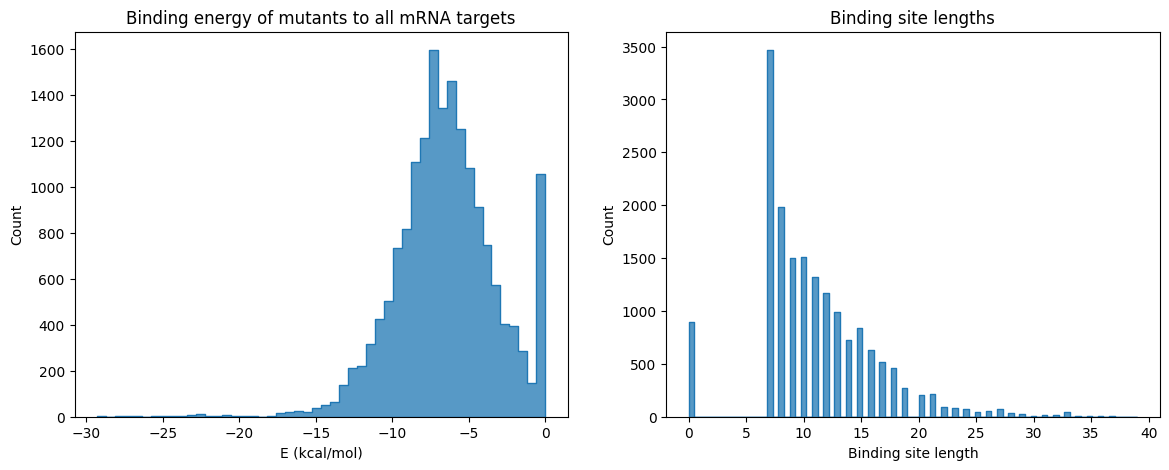

In [46]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(1,2,1)
sns.histplot(df_mutations, x='E (kcal/mol)', element='step', bins=50)
plt.title('Binding energy of mutants to all mRNA targets')
ax = plt.subplot(1,2,2)
sns.histplot(df_mutations, x='Binding site length', element='step', bins=80)
plt.title('Binding site lengths')


Text(0.5, 1.0, 'Binding energy of Syn_ChiX_20-D to official mRNA targets')

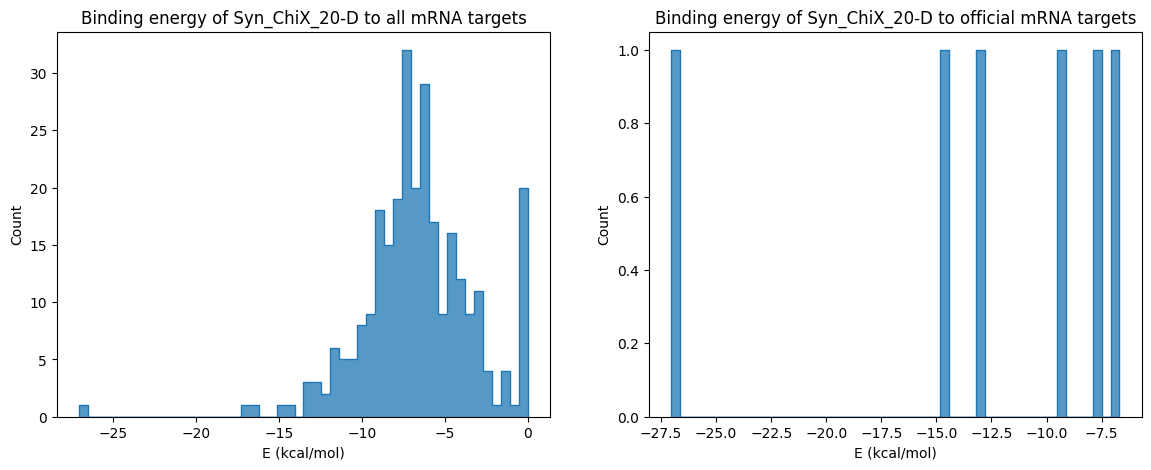

In [47]:
fig = plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(df_mutations[df_mutations['Interactor 1'] ==
             'Syn_ChiX_20-D'], x='E (kcal/mol)', element='step', bins=50)
plt.title('Binding energy of Syn_ChiX_20-D to all mRNA targets')
ax = plt.subplot(1, 2, 2)
sns.histplot(df_mutations[(df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())) & (
    df_mutations['Interactor 1'] == 'Syn_ChiX_20-D')], x='E (kcal/mol)', element='step', bins=50)
plt.title('Binding energy of Syn_ChiX_20-D to official mRNA targets')

### Energy differences

Text(0.5, 0.98, 'Binding energy to all mRNAs differences between synthetic ChiX and its mutants')

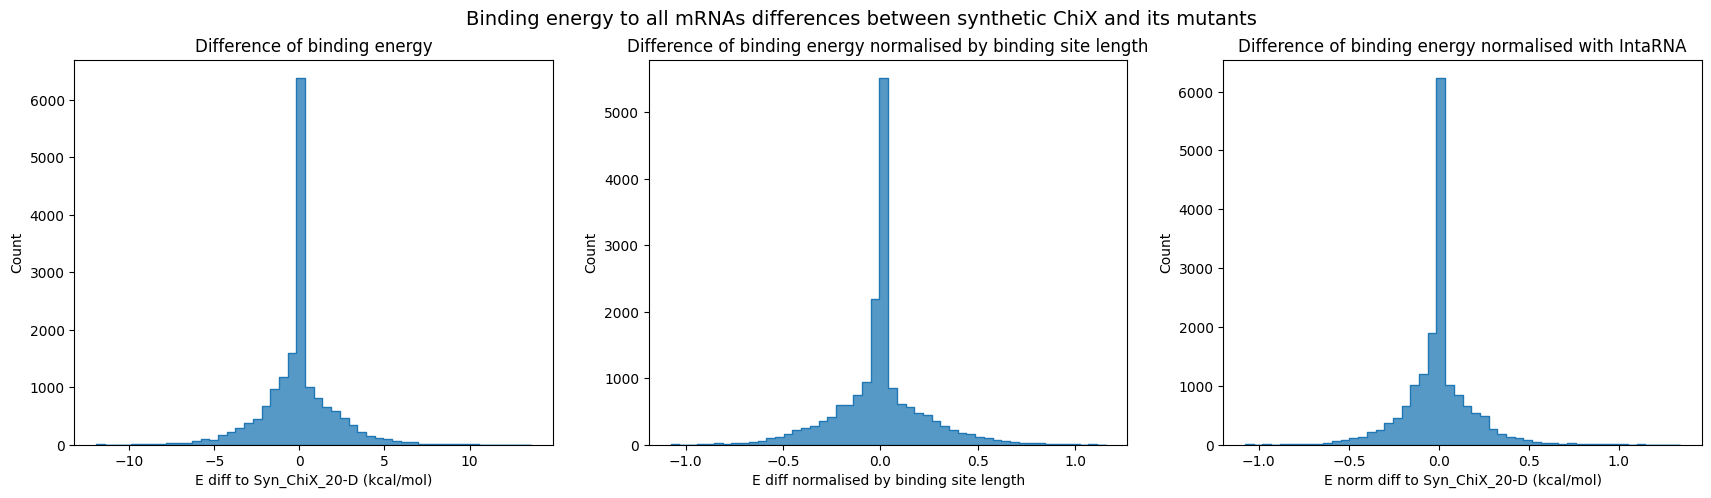

In [48]:
fig = plt.figure(figsize=(21, 5))
ax = plt.subplot(1,3,1)
sns.histplot(df_mutations, x='E diff to Syn_ChiX_20-D (kcal/mol)', element='step', bins=50)
plt.title('Difference of binding energy')
ax = plt.subplot(1,3,2)
sns.histplot(df_mutations, x='E diff normalised by binding site length', element='step', bins=50)
plt.title('Difference of binding energy normalised by binding site length')
ax = plt.subplot(1,3,3)
sns.histplot(df_mutations, x='E norm diff to Syn_ChiX_20-D (kcal/mol)', element='step', bins=50)
plt.title('Difference of binding energy normalised with IntaRNA')

plt.suptitle('Binding energy to all mRNAs differences between synthetic ChiX and its mutants', fontsize=14)

Text(0.5, 0.98, 'Binding energy to official target RNAs differences between synthetic ChiX and its mutants')

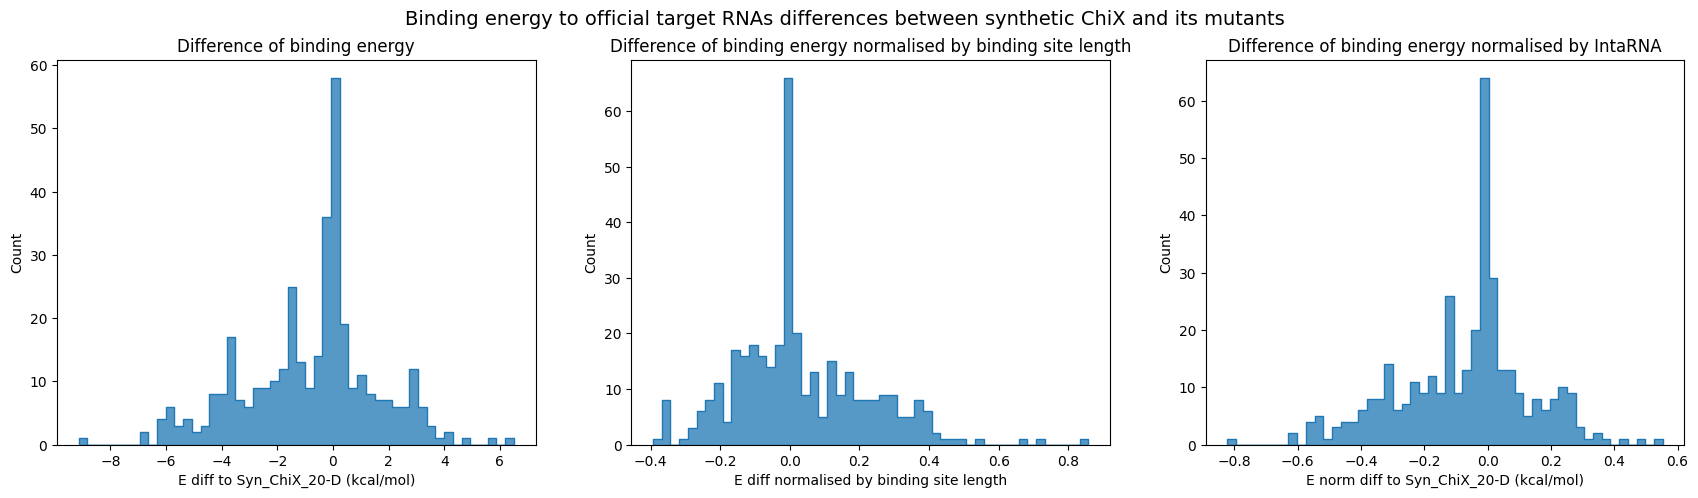

In [49]:
fig = plt.figure(figsize=(21, 5))
ax = plt.subplot(1,3,1)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='E diff to Syn_ChiX_20-D (kcal/mol)', element='step', bins=50)
plt.title('Difference of binding energy')
ax = plt.subplot(1,3,2)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='E diff normalised by binding site length', element='step', bins=50)
plt.title('Difference of binding energy normalised by binding site length')
ax = plt.subplot(1,3,3)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='E norm diff to Syn_ChiX_20-D (kcal/mol)', element='step', bins=50)
plt.title('Difference of binding energy normalised by IntaRNA')

plt.suptitle('Binding energy to official target RNAs differences between synthetic ChiX and its mutants', fontsize=14)

### Structural differences

<Axes: xlabel='Num in seq diff sum', ylabel='E diff to Syn_ChiX_20-D (kcal/mol)'>

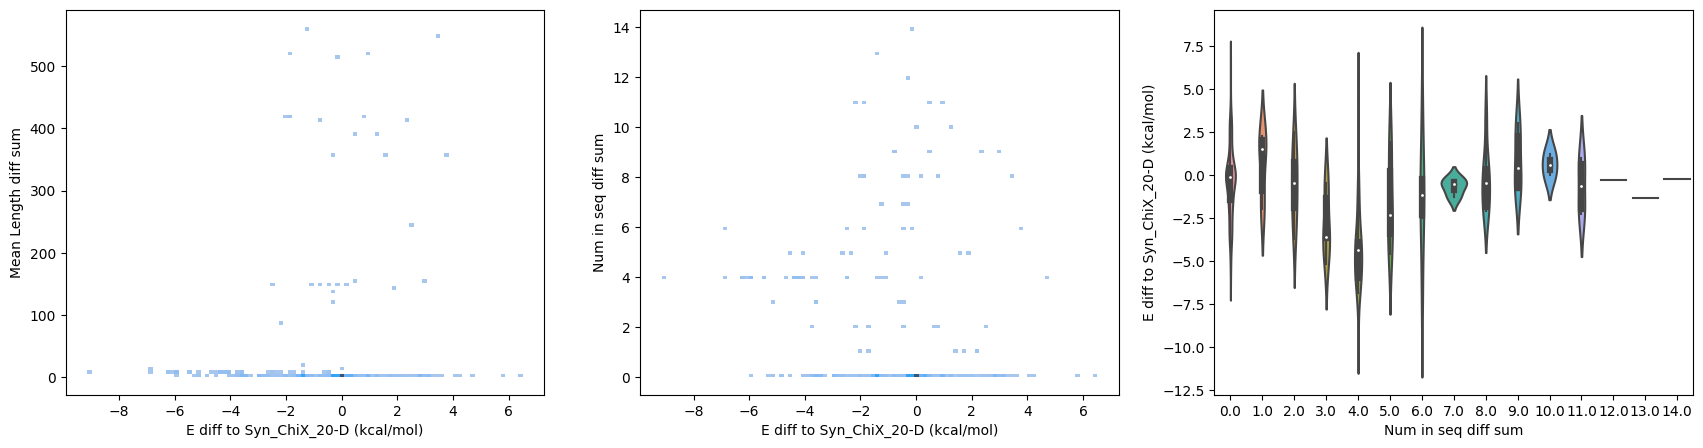

In [50]:
fig = plt.figure(figsize=(21, 5))
ax = plt.subplot(1,3,1)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='E diff to Syn_ChiX_20-D (kcal/mol)', y='Mean Length diff sum', bins=100, element='step')
ax = plt.subplot(1,3,2)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='E diff to Syn_ChiX_20-D (kcal/mol)', y='Num in seq diff sum', bins=100, element='step')
ax = plt.subplot(1,3,3)
sns.violinplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], y='E diff to Syn_ChiX_20-D (kcal/mol)', x='Num in seq diff sum') #, bins=100) # element='step', 


Text(0.5, 0, 'E (kcal/mol)')

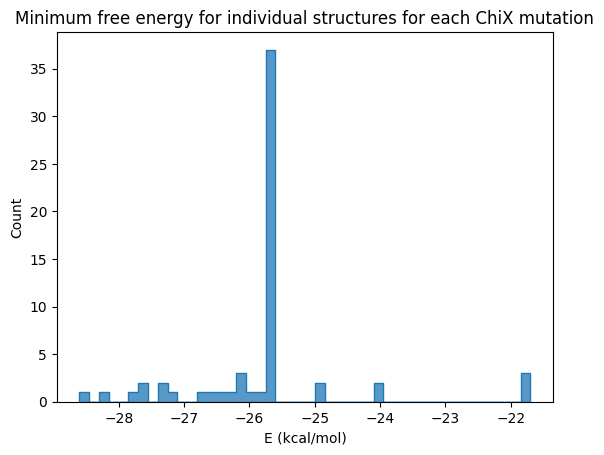

In [51]:

for k, v in muts.items():
    if type(v) == str:
        muts[k] = {}
        muts[k]['Sequence'] = v
    muts[k]['E'] = ViennaRNA.fold(muts[k]['Sequence'])[1]
    
sns.histplot([v['E'] for v in muts.values()], element='step')
plt.title('Minimum free energy for individual structures for each ChiX mutation')
plt.xlabel('E (kcal/mol)')

Text(0.5, 0.98, 'Structural features: difference between mutated and original interactions')

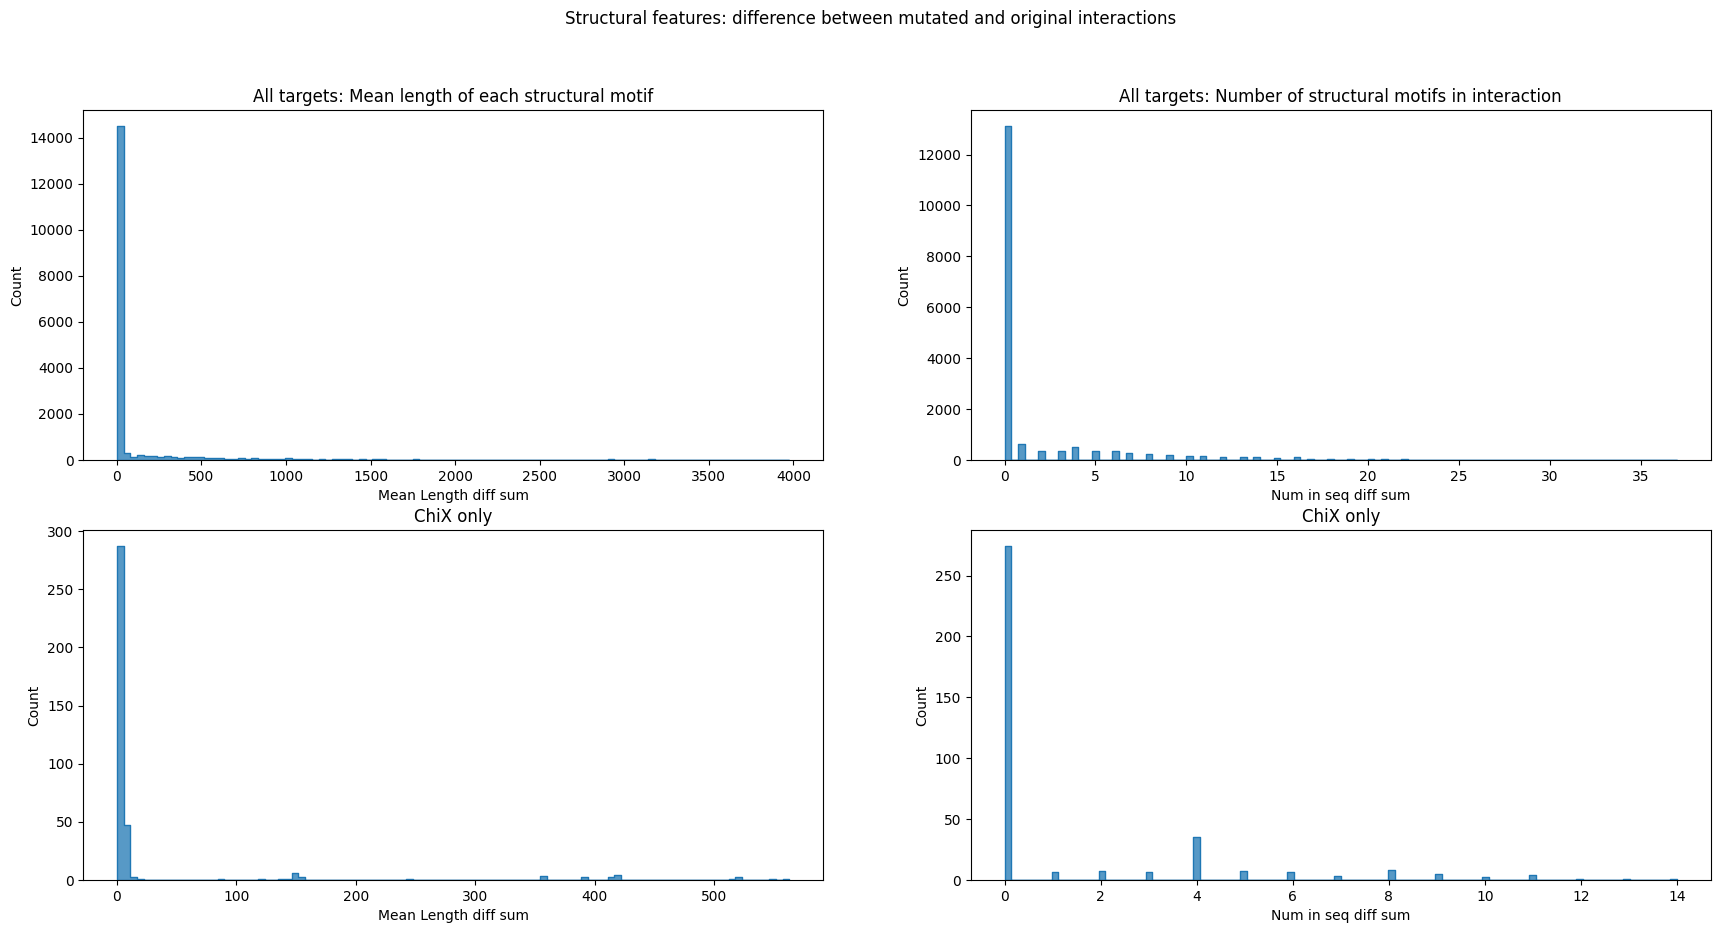

In [52]:
fig = plt.figure(figsize=(21, 10))

ax1 = plt.subplot(2,2,1)
sns.histplot(df_mutations, x='Mean Length diff sum', element='step', bins=100, log_scale=[False, False])
plt.title('All targets: Mean length of each structural motif')
ax2 = plt.subplot(2,2,2)
sns.histplot(df_mutations, x='Num in seq diff sum', element='step', bins=100, log_scale=[False, False])
plt.title('All targets: Number of structural motifs in interaction')
ax = plt.subplot(2,2,3)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='Mean Length diff sum', element='step', bins=100, log_scale=[False, False])
plt.title('ChiX only')
# ax.set_ylim(ax1.get_ylim())
# ax.set_xlim(ax1.get_xlim())
ax = plt.subplot(2,2,4)
sns.histplot(df_mutations[df_mutations['Interactor 2'].isin(chix['Interactor 2'].to_list())], x='Num in seq diff sum', element='step', bins=100, log_scale=[False, False])
plt.title('ChiX only')
# ax.set_ylim(ax2.get_ylim())
# ax.set_xlim(ax2.get_xlim())

plt.suptitle('Structural features: difference between mutated and original interactions')

### ChiX binding EGFP and cyRFP1

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GATTTGTAACTAAAAACAAGAAACTTATGGTATCAAAAGGTGAAGAGCTGATTAAAGAGAACATGAGATCAAAGCTTTACTTAGAAGGCTCTGTGAATGGCCATCAGTTCAAATGCACCCACGAGGGTGAAGGGAAACCTTATGAGGGTAAACAGACCAATCGAATTAAGGTTGTGGAAGGCGGCCCCTTACCTTTTGCATTCGACATATTGGCGACGATGTTCATGTACGGCTCTAAGGTTTTCATCAAATATCCGGCAGATTTGCCCGATTACTTCAAACAATCCTTTCCGGAGGGCTTTACATGGGAAAGAGTAATGGTGTTTGAAGACGGTGGTGTGCTGACTGCAACACAGGATACCTCACTTCAGGATGGTGAACTGATCTACAACGTGAAACTGCGAGGAGTTAACTTTCCAGCAAATGGGCCAGTGATGCAAAAAAAAACCCTGGGATGGGAACCATCTACAGAAACGATGTATCCCGCCGATGGCGGATTAGAGGGAAGGTGCGATAAAGCTCTGAAACTCGTTGGCGGCGGTCATTTACATGTGAACTTCAAAACGACTTATAAAAGTAAGAAACCGGTTAAGATGCCGGGCGTACACTATGTGGATCGACGTTTGGAACGGATAAAAGAGGCGGATAACGAAACTTACGTGGAGCAGTACGAACATGCTGTAGCCCGGTATAGCAACTTAGGTGGCGGTATGGACGAACTTTATAAATAA', '-structureDBN', '.((((((((........................((((((((((.((((((((......(..(((.....((.((((((......)))))).))...)))..))))))))).....(((((....)))))((((....))))..((.(((..

Output file: /tmp/tmpuavr_fdc.png



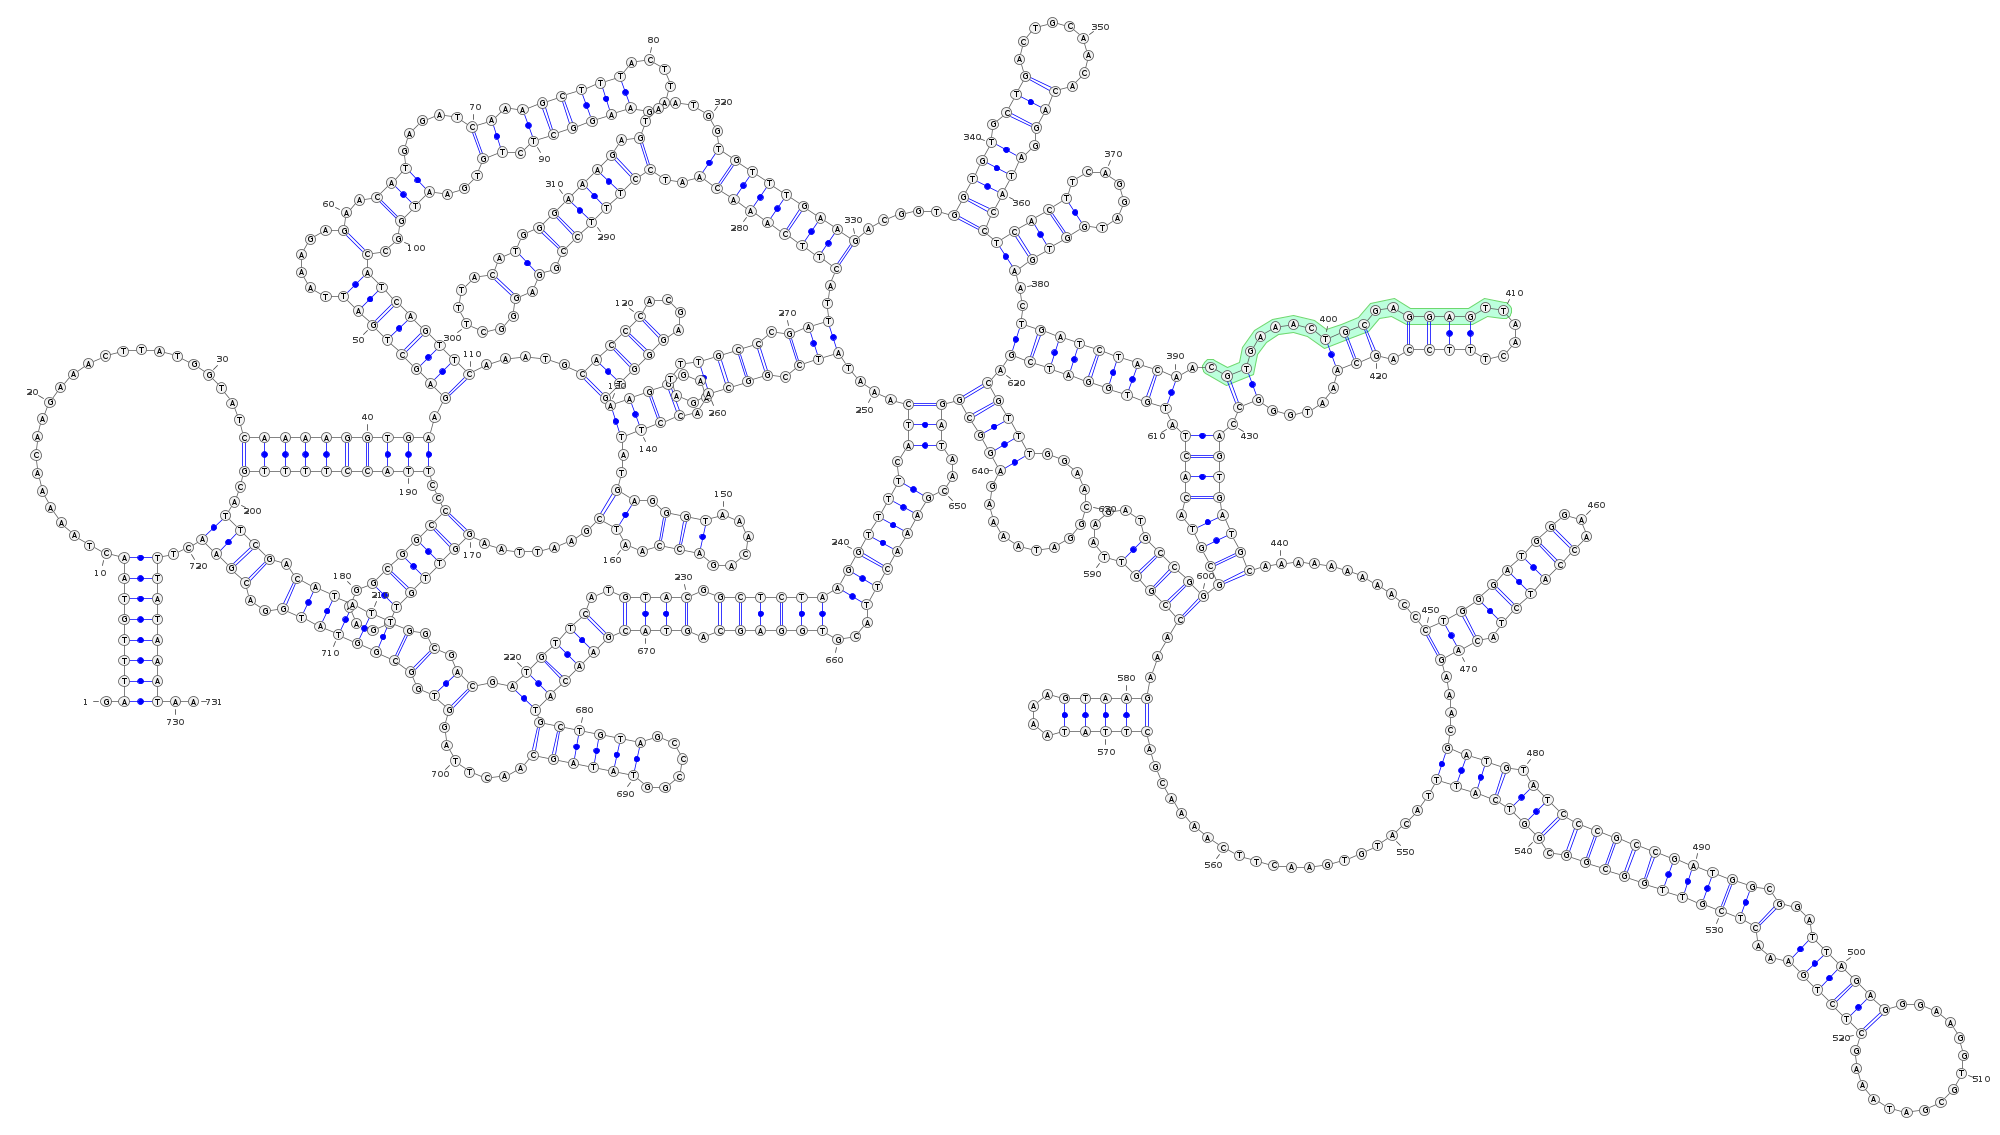

In [53]:
start_end = string_to_tuple_list(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['bpList'])
show_rna_structure(ViennaRNA.fold(cyrfp1_seq)[0], cyrfp1_seq, resolution=5,
                   highlight_kwrgs={
                       'i': start_end[0][0],
                       'j': start_end[-1][0]
                    #    'i': int(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['seedStart1']),
                    #    'j': int(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['seedEnd1'])
})

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'TACTAGAGAAAGAGGGGAAATACTAGTACCATATGCGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCGGTTATGGTGTTCAATGCTTTGCGAGATACCCAGATCATATGAAACAGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAAAGAACTATATTTTTCAAAGATGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATAGAATCGAGTTAAAAGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAATTGGAATACAACTATAACTCACACAATGTATACATCATGGCAGACAAACAAAAGAATGGAATCAAAGTTAACTTCAAAATTAGACACAACATTGAAGATGGAAGCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGATCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAA', '-structureDBN', '((((((................))))))(((..(((....(((((((....))))).))..((((((.((((((..((((.((.....((((.(((..((((((......((((((((.((((.((((((((.

Output file: /tmp/tmp9sf6k3hm.png


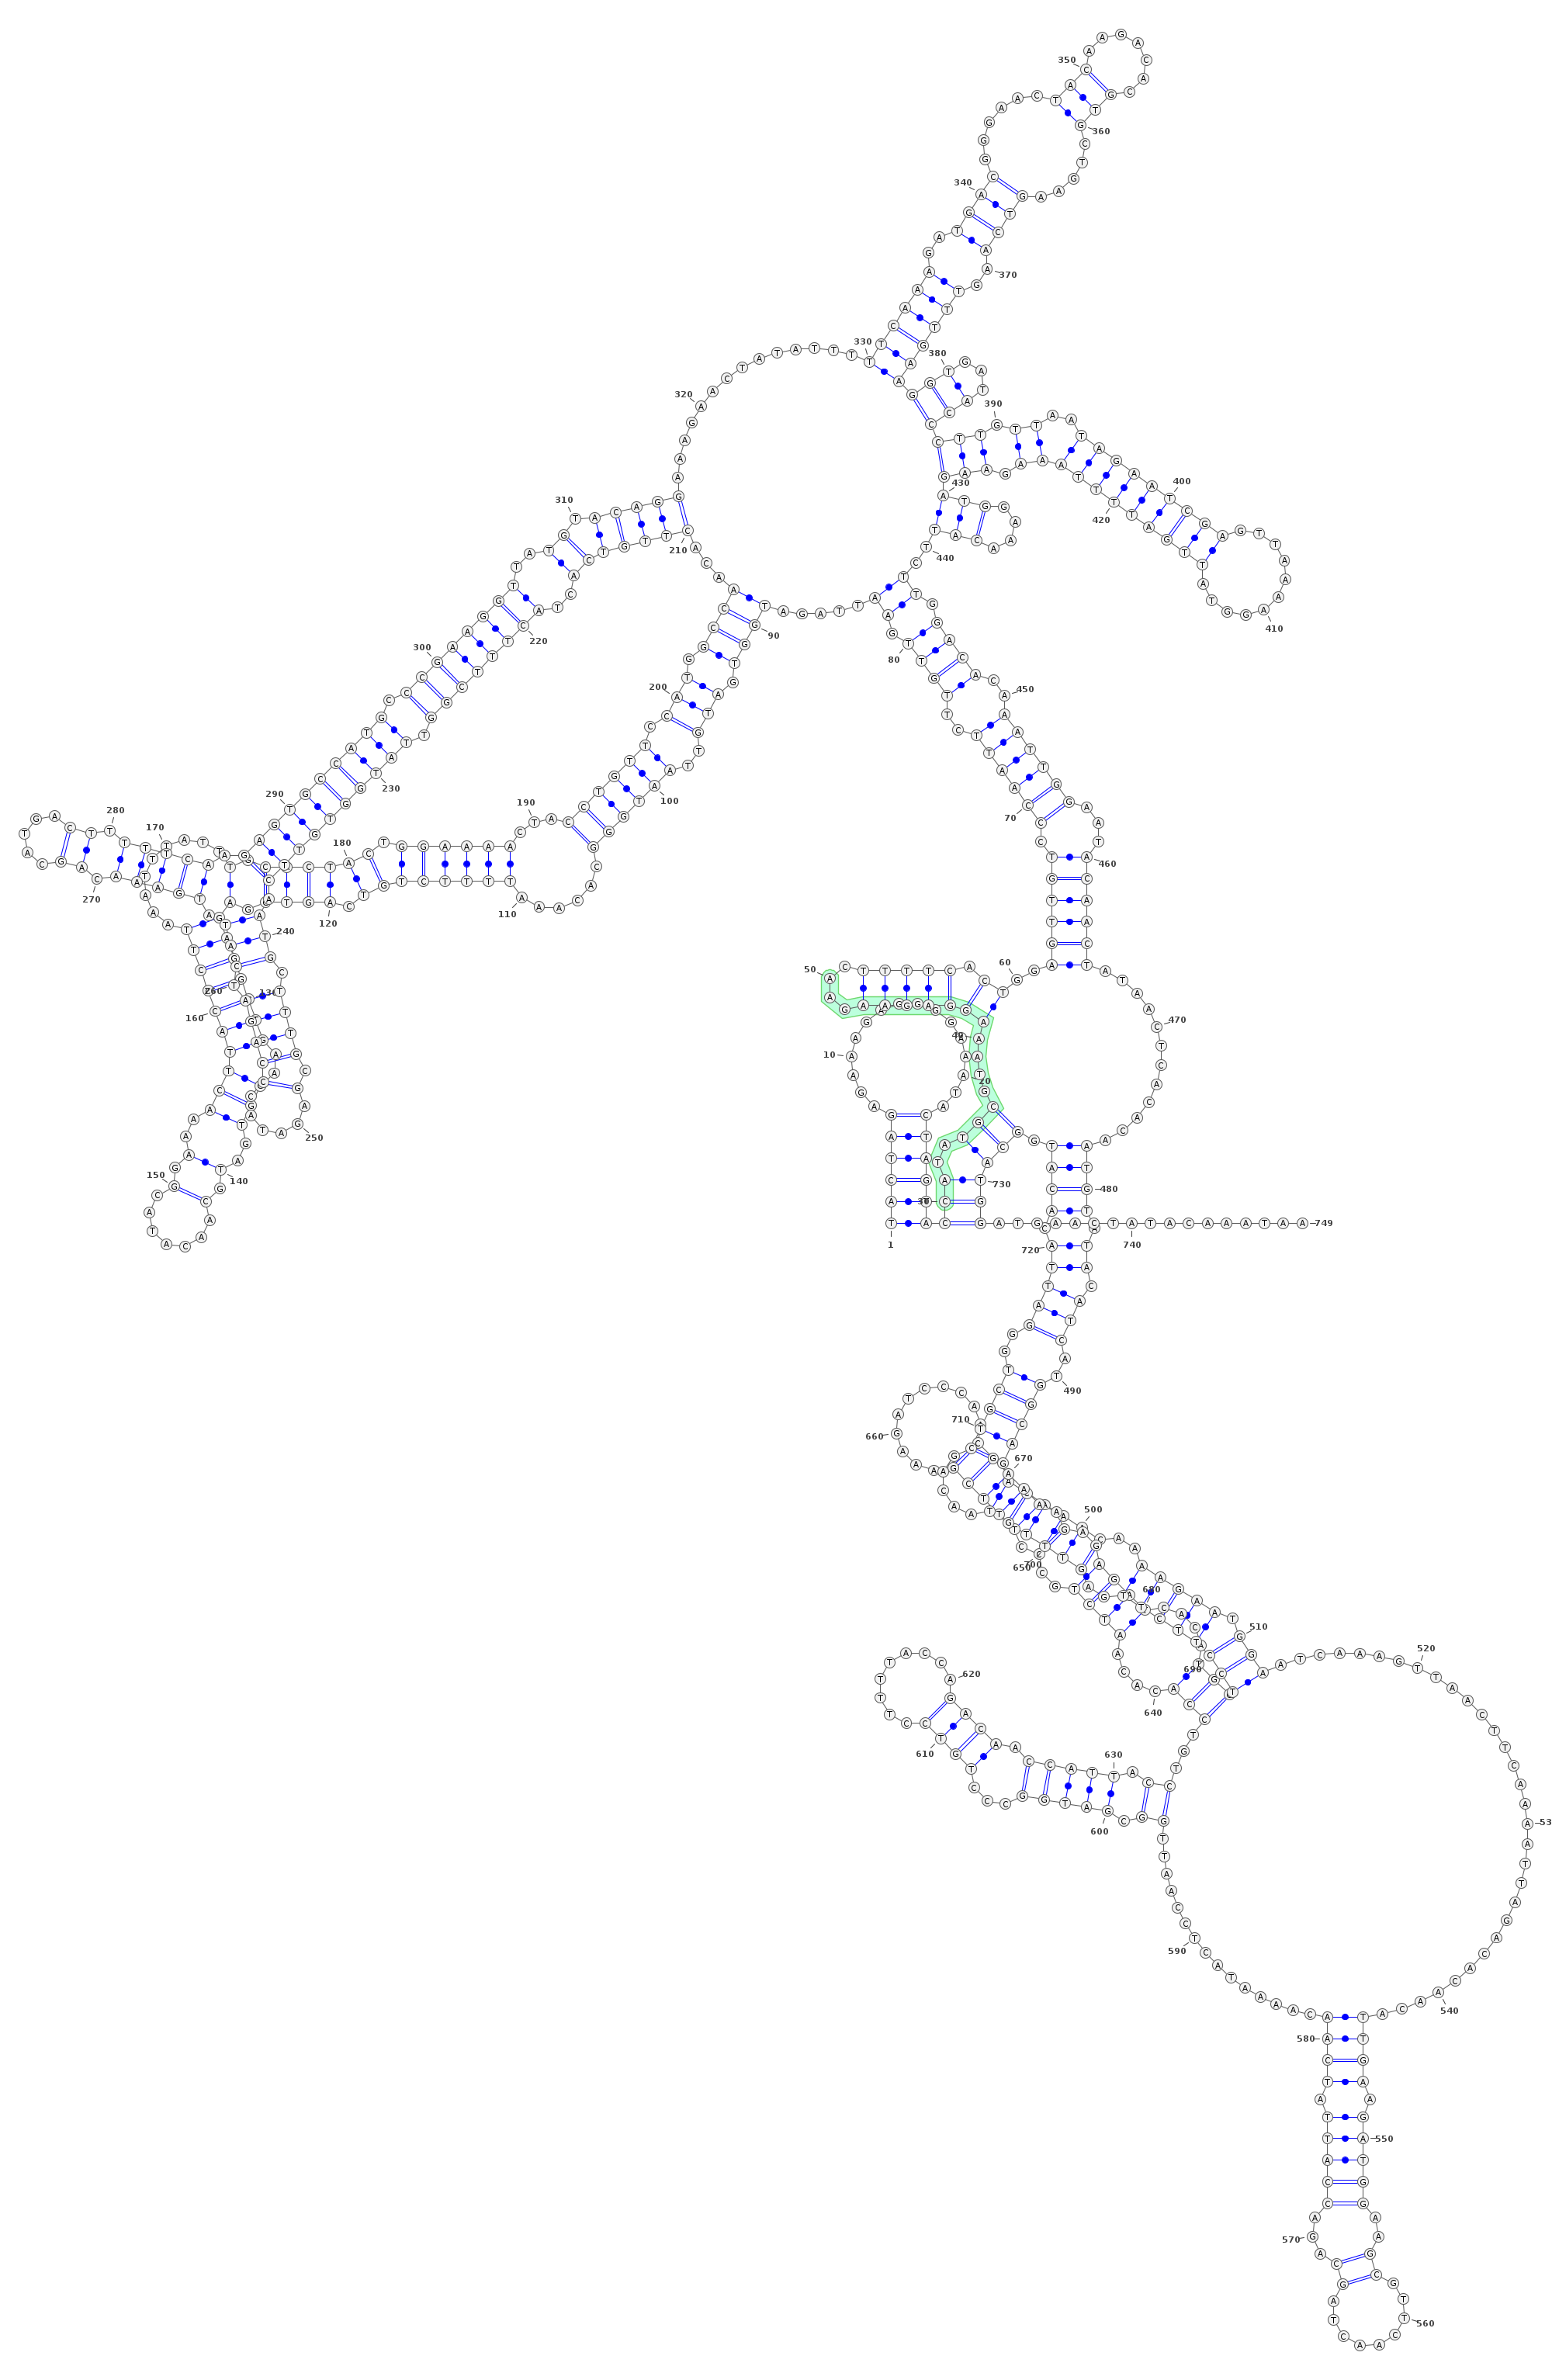

In [54]:
start_end = string_to_tuple_list(sim_data_l['Syn_ChiX_20-D']['EGFP']['bpList'])
show_rna_structure(ViennaRNA.fold(egfp_seq)[0], egfp_seq, resolution=5,
                   highlight_kwrgs={
                       'i': start_end[0][0],
                       'j': start_end[-1][0]
                    #    'i': int(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['seedStart1']),
                    #    'j': int(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['seedEnd1'])
})

# Ranking of mutants

In [55]:
sim_data_l['Syn_ChiX_20-D']['acnA']

{'id1': 'acnA',
 'id2': 'Syn_ChiX_20-D',
 'E': '-11.59',
 'E_norm': '-0.934456',
 'bpList': '(2198,59):(2199,58):(2200,57):(2201,56):(2203,55):(2204,54):(2205,53):(2206,52):(2207,51):(2208,50):(2209,49):(2210,48):(2211,47)',
 'hybridDPfull': '.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [56]:
for c in ['seedPu1', 'seedPu2', 'seedStart1', 'seedStart2', 'seedEnd1', 'seedEnd2']:
    df_mutations[c + '_'] = list(map(lambda x: np.array([float(xx) for xx in x]) if x[0] else np.array([]), df_mutations[c].str.split(':')))
    
    
df_mutations['weighted_seedPu1'] = list(map(lambda a, s, e: np.mean(a * (e - s) / (np.sum(np.abs(e - s)))), df_mutations['seedPu1' + 'uh'], df_mutations['seedStart1' + 'uh'], df_mutations['seedEnd1' + 'uh']))
df_mutations['weighted_seedPu2'] = list(map(lambda a, s, e: np.mean(a * (e - s) / (np.sum(np.abs(e - s)))), df_mutations['seedPu2' + 'uh'], df_mutations['seedStart2' + 'uh'], df_mutations['seedEnd2' + 'uh']))

KeyError: 'seedPu1uh'

In [ ]:
df_mutations['E'] = df_mutations['E'].apply(float)

In [ ]:
from typing import List


def score_similarity(target, og_val):
    return target - og_val


def rna_objective(data: pd.DataFrame, ref: str,
                  stronger: List[str], same: List[str], weaker: List[str],
                  e_weight: float = 1.0, a_weight: float = 1.0, s_weight: float = 1.0):
    """ The binding energy, the accessibility of the seed region, and the structural changes are the key parameters that we can use to optimise for new RNAs.
    The data variable should have a column for the source RNA and for the target RNA, and the mutations should be in the source RNA column. """

    source_col = 'Interactor 1'
    target_col = 'Interactor 2'
    data['score_energy'] = 0
    data['score_access'] = 0
    data['score_struct'] = 0
    data['score'] = 0

    for t in data[target_col].unique():

        param = 'E'
        e_score = score_similarity(
            target=data[data[target_col] == t][param].to_numpy(), og_val=data[(data[source_col] == ref) & (data[target_col] == t)][param].to_numpy())
        param = 'weighted_seedPu1'
        a_score = score_similarity(
            target=data[data[target_col] == t][param].to_numpy(), og_val=data[(data[source_col] == ref) & (data[target_col] == t)][param].to_numpy())
        param = 'Num in seq diff sum'
        s_score = score_similarity(
            target=data[data[target_col] == t][param].to_numpy(), og_val=data[(data[source_col] == ref) & (data[target_col] == t)][param].to_numpy())

        if t in stronger:

            data.loc[data[target_col] == t, 'score_energy'] = -1 * e_score
            data.loc[data[target_col] == t, 'score_access'] = a_score

        elif t in weaker:
            data.loc[data[target_col] == t, 'score_energy'] = e_score
            data.loc[data[target_col] == t, 'score_access'] = -1 * a_score

        elif t in same:
            data.loc[data[target_col] == t, 'score_energy'] = -1 * np.abs(e_score)
            data.loc[data[target_col] == t, 'score_access'] = -1 * np.abs(a_score)

        data.loc[data[target_col] == t, 'score_struct'] = -1 * np.abs(s_score)

    for s in ['score_energy', 'score_access', 'score_struct']:
        data[s] = np.interp(data[s].to_numpy(), [data[s].min(), 0, data[s].max()], [-1, 0, 1])
    data['score'] = (
        a_weight * data['score_access']
        ) + (e_weight * data['score_energy']
             ) + (s_weight * data['score_struct'])
    data['score'] = np.interp(data['score'].to_numpy(), [data['score'].min(), 0, data['score'].max()], [-1, 0, 1])

    return data


stronger = ['EGFP', 'cyRFP1']
same = [i for i in chix['Interactor 2'].to_list() if i not in stronger]
weaker = [i for i in data['Interactor 2'].unique() if (i not in same)
          and (i not in stronger)]
df_mutations = rna_objective(
    df_mutations, ref='Syn_ChiX_20-D', stronger=stronger, same=same, weaker=weaker,
    s_weight=0)

Text(0.5, 1.0, 'Structure score')

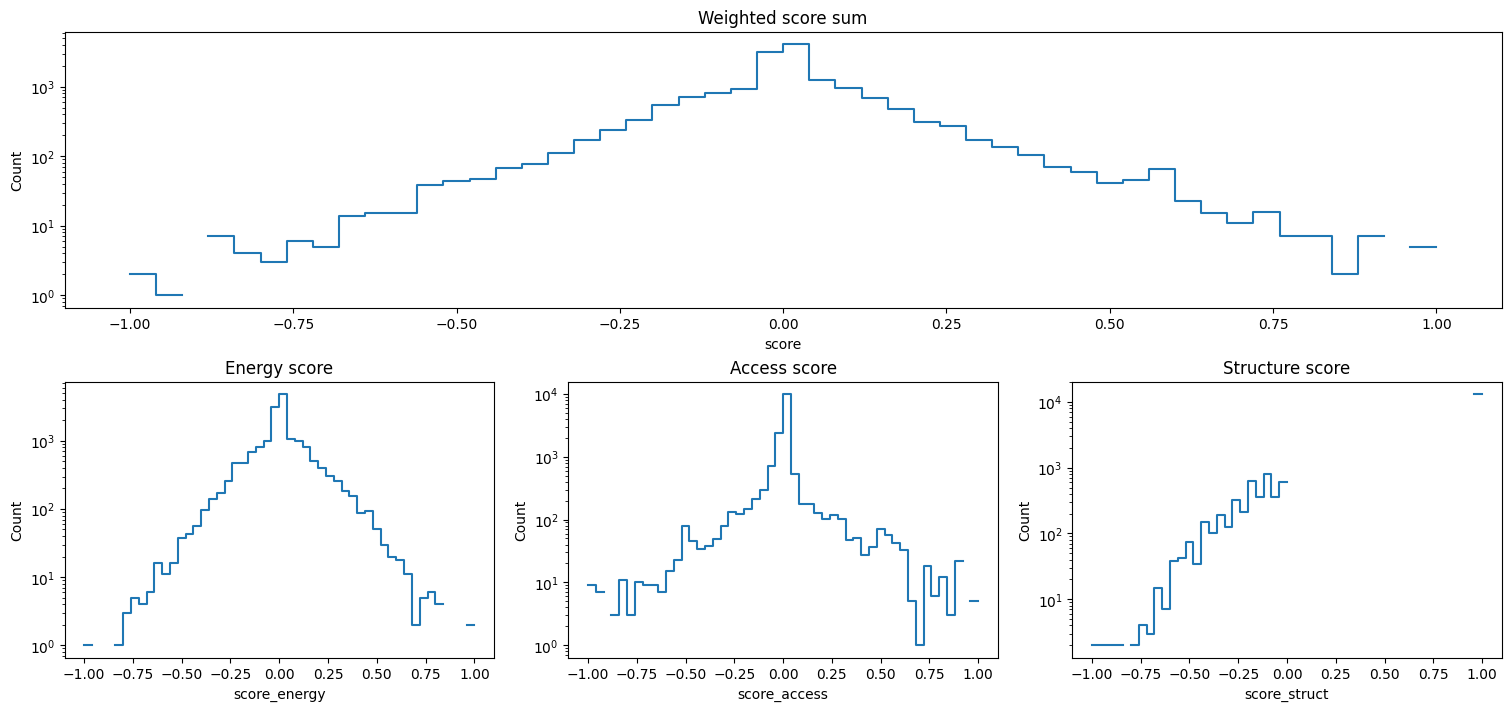

In [ ]:
fig = plt.figure(figsize=(15, 7), layout="constrained")
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
sns.histplot(df_mutations, x='score', bins=50, log_scale=[False, True], element='step', fill=False, ax=ax1)
sns.histplot(df_mutations, x='score_energy', bins=50, log_scale=[False, True], element='step', fill=False, ax=ax2)
sns.histplot(df_mutations, x='score_access', bins=50, log_scale=[False, True], element='step', fill=False, ax=ax3)
sns.histplot(df_mutations, x='score_struct', bins=50, log_scale=[False, True], element='step', fill=False, ax=ax4)
ax1.set_title('Weighted score sum')
ax2.set_title('Energy score')
ax3.set_title('Access score')
ax4.set_title('Structure score')


In [ ]:
for s in ['score_energy', 'score_access', 'score_struct']:
    df_mutations[s + '_pos'] = df_mutations[s] > 0

In [ ]:
df_agg = df_mutations.groupby(by=['Interactor 1']).agg({s: 'mean' for s in ['score', 'score_energy', 'score_access', 'score_struct']})
for s in ['score_energy', 'score_access', 'score_struct']:
    df_agg[s + '_pos'] = df_agg[s] > 0
    df_agg[s + '_pos']
df_agg.sort_values(by=['score_energy' + '_pos', 'score_access' + '_pos', 'score'], ascending=False).to_csv('sorted_mutations.csv')
df_agg.sort_values(by=['score_energy' + '_pos', 'score_access' + '_pos', 'score'], ascending=False)

,score,score_energy,score_access,score_struct,score_energy_pos,score_access_pos,score_struct_pos
Interactor 1,,,,,,,
MutagenesisVariant_4,0.043029,0.042485,0.012740,0.744055,True,True,True
MutagenesisVariant_3,0.042066,0.024308,0.028306,0.603572,True,True,True
MutagenesisVariant_10,0.028813,0.028666,0.011187,0.686754,True,True,True
MutagenesisVariant_13,0.027561,0.034342,0.003565,0.676442,True,True,True
MutagenesisVariant_12,0.027424,0.014915,0.019059,0.585394,True,True,True
...,...,...,...,...,...,...,...
MutagenesisVariant_36,-0.087419,-0.113285,0.013976,0.673184,False,True,True
Syn_ChiX_20-D,0.000000,0.000000,0.000000,1.000000,False,False,True
MutagenesisVariant_20,-0.009477,-0.002734,-0.011598,0.675964,False,False,True
